# Mi primer modelo de Machine Learning

## Objetivo:

Conocer de forma general los pasos a seguir para construir un modelo de aprendizaje automático que pueda resolver un problema en específico. En este taller vamos a entrenar tres modelos de clasificación supervisada y a seleccionar el mejor, el cual nos ayudará a detectar cargos/movimientos fraudulentos en las tarjetas de crédito de los clientes de cierto banco.

## ¡Manos a la computadora!

In [1]:
# Importar librerías de utilidad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargar base de datos a un Pandas DataFrame para poder manipularlo
url = 'https://raw.githubusercontent.com/DillanAS/Taller_MiPrimerModeloDeML/main/fraud_detection.csv'

df = pd.read_csv(url, index_col= 'cust_id', error_bad_lines = False)

De nuestra base de datos vamos a extraer una muestra aleatoria del 15% de las observaciones. Esta base de datos nos servirá más adelante para simular datos "nuevos" para nuestro modelo de aprendizaje automático.

In [3]:
X_sample = df.sample(frac = 0.15, replace = False, random_state = 2021).drop('fraud', axis = 1)

Realicemos una breve exploración de nuestra base de datos, con el objetivo de obtener información sobre las variables, su escala de medición y si tenemos missing values:

In [4]:
pd.set_option('max_columns', 20)
print(df.head())
print(df.shape)

             balance  purchases  installments_purchases  cash_advance  \
cust_id                                                                 
C10001     40.900749      95.40                    95.4      0.000000   
C10002   3202.467416       0.00                     0.0   6442.945483   
C10003   2495.148862     773.17                     0.0      0.000000   
C10004   1666.670542    1499.00                     0.0    205.788017   
C10005    817.714335      16.00                     0.0      0.000000   

         credit_limit     payments  minimum_payments  fraud  
cust_id                                                      
C10001         1000.0   201.802084        139.509787      0  
C10002         7000.0  4103.032597       1072.340217      0  
C10003         7500.0   622.066742        627.284787      0  
C10004         7500.0     0.000000        864.173246      0  
C10005         1200.0   678.334763        244.791237      0  
(8950, 8)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C18950
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   balance                 8950 non-null   float64
 1   purchases               8950 non-null   float64
 2   installments_purchases  8950 non-null   float64
 3   cash_advance            8950 non-null   float64
 4   credit_limit            8950 non-null   float64
 5   payments                8950 non-null   float64
 6   minimum_payments        8950 non-null   float64
 7   fraud                   8950 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 629.3+ KB
None


## Análisis Exploratorio de Datos (EDA)
Una vez confirmado que la base de datos está lista para ser utilizada, comencemos con el análisis exploratorio de los datos (EDA).

Este es un punto muy importante y debe ser lo primero que desarrolles antes de comenzar a construir tus modelos de aprendizaje automático.

In [6]:
X = df.drop('fraud', axis = 1)
print(X.shape)
print(X.describe().T.round(2))

(8950, 7)
                         count     mean      std    min      25%      50%  \
balance                 8950.0  1564.61  2081.50   0.00   128.28   873.94   
purchases               8950.0  1003.20  2136.63   0.00    39.64   361.28   
installments_purchases  8950.0   411.07   904.34   0.00     0.00    89.00   
cash_advance            8950.0   978.98  2086.58   0.00     0.00     0.00   
credit_limit            8950.0  4494.45  3638.61  50.00  1600.00  3000.00   
payments                8950.0  1733.14  2895.06   0.00   383.28   856.90   
minimum_payments        8950.0   864.17  2330.50   0.02   170.88   335.69   

                            75%       max  
balance                 2054.14  19043.14  
purchases               1110.13  49039.57  
installments_purchases   468.64  22500.00  
cash_advance            1096.91  47137.21  
credit_limit            6500.00  30000.00  
payments                1901.13  50721.48  
minimum_payments         864.17  76406.21  


¿Qué análisis puedes obtener de la estadística descriptiva de las variables explicativas? ¿Qué tipo de variables son? ¿Cuál es su escala de medición? ¿El rango de las variables puede ser un problema para la estimación?

¡Analizar la información es súper importante!

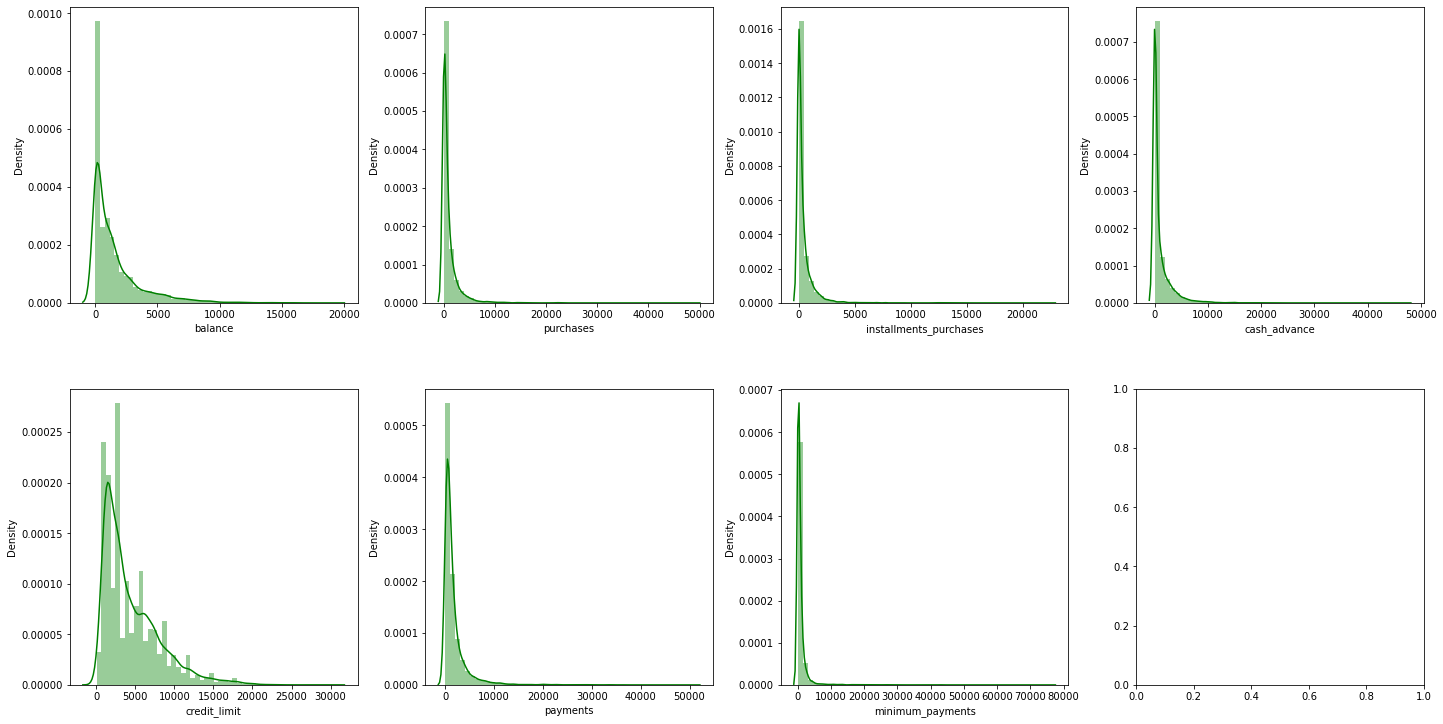

In [7]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()

for col, value in X.items():
    sns.distplot(value, color='g', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

¿Qué implicaciones tiene la distribución de las variables sobre el poder explicativo de nuestros modelos de clasificación? 

(8950,)
   y_variable  percentage_count
1           1          0.007821
0           0          0.992179


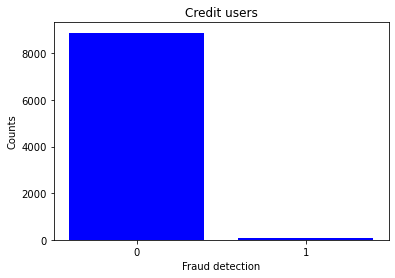

In [8]:
y = df['fraud']
print(y.shape)
print(y.value_counts(normalize = True).reset_index().rename(columns = {'index': 'y_variable', 'fraud': 'percentage_count'}).sort_values(by = "percentage_count"))

labels, counts = np.unique(y, return_counts=True)
plt.bar(labels, counts, align='center', color = "b")
plt.title('Credit users')
plt.xlabel('Fraud detection')
plt.ylabel("Counts")
plt.xticks(labels)
plt.show()

¿Qué reto podría representar tener una distribución de frecuencias como esta?

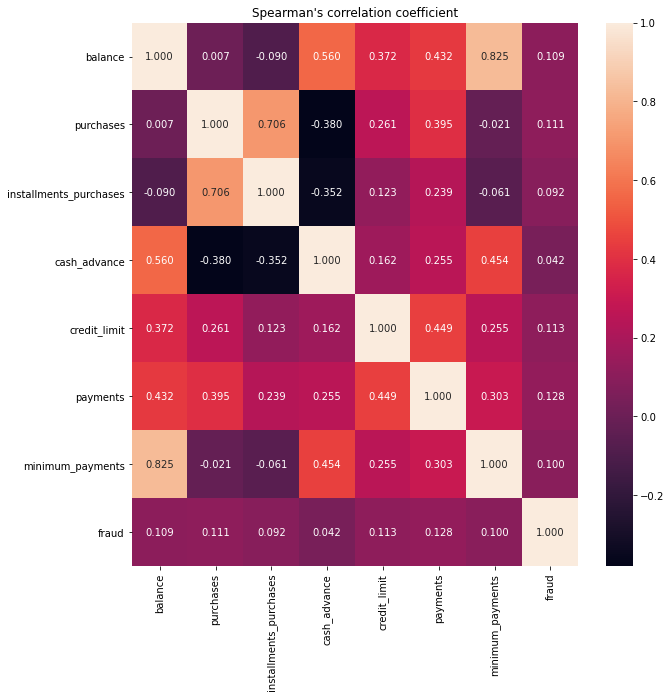

In [9]:
corr_spearman = df.corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_spearman, annot = True, fmt=".3f").set_title(
    "Spearman's correlation coefficient")
plt.show()

Ahora sí, ¿qué podemos concluir respecto a la clasificación de nuestras variables explicativas y nuestra variable objetivo?

# Preprocesamiento de Datos
Una vez concluído el EDA, debemos realizar todas las transformaciones necesarias en nuestras variables, ya que de ello dependerá, en gran parte, el éxito de nuestros modelos

In [10]:
from sklearn.preprocessing import PowerTransformer

In [11]:
# Vamos a hacer una transformación logarítmica de nuestras variables explicativas
pwt = PowerTransformer()
X_pwt = pwt.fit_transform(X)

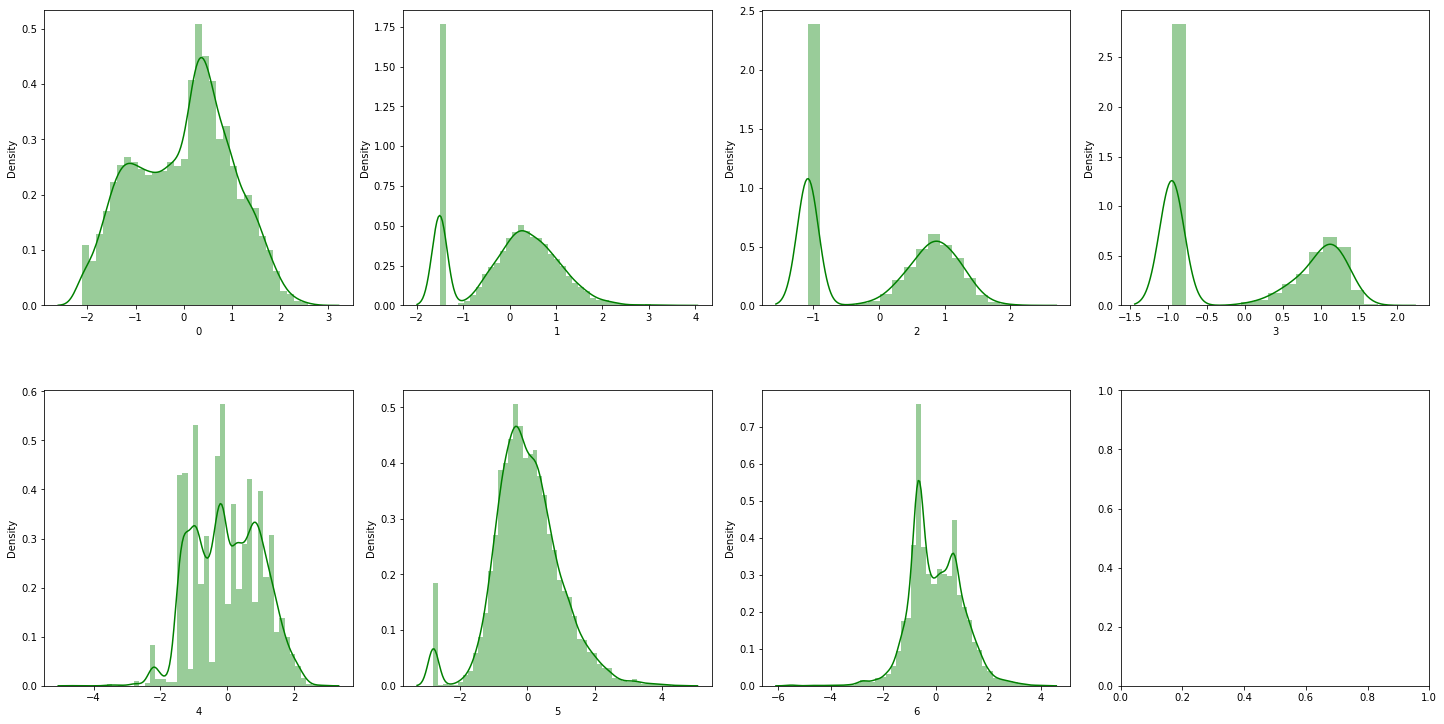

In [12]:
X_pwt_df = pd.DataFrame(X_pwt)

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()

for col, value in X_pwt_df.items():
    sns.distplot(value, color='g', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

## Supervised Machine Learning

Con todo el análisis exploratorio de datos ya tenemos una idea detallada del comportamiento de nuestros datos y de cómo debemos procesarlos para dárselos a nuestro modelo.

¿Están listos? ¡Es momento de construir nuestros primeros algoritmos y entrenarlos!

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

¿Recuerdas cómo debemos entrenar nuestro modelo?

Tenemos que darle una serie de ejercicios de entrenamiento y luego ponerlo a prueba con datos que nunca antes haya visto ... pero que podamos evaluar para medir su desempeño.

Vamos a separar nuestra base de datos, de forma aleatoria, en un conjunto para entrenamiento y otro para prueba

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_pwt, y, test_size=0.20, stratify = y, random_state=42)

print('--------Train set--------')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('--------Test set---------')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

--------Train set--------
X_train shape: (7160, 7)
y_train shape: (7160,)
--------Test set---------
X_test shape: (1790, 7)
y_test shape: (1790,)


Como vimos anteriormente, nuestra variable objetivo no está balanceada; tenemos muy pocos clientes que han caído en fraude. Aunque esto es afortunado para el banco, no lo es para nuestro modelo, ya que tendrá muy pocos casos de fraude de los cuales aprender.

Para solucionar este problema y colaborar con el aprendizaje de nuestro modelo, realizaremos un remuestreo para balancear las clasificaciones.

In [15]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
X_test, y_test = over_sampler.fit_resample(X_test, y_test)

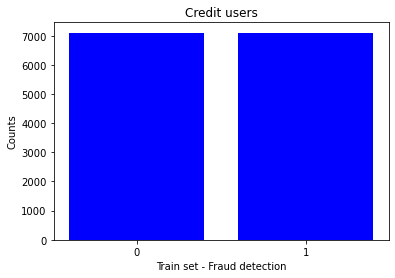

In [16]:
labels, counts = np.unique(y_train, return_counts=True)
plt.bar(labels, counts, align='center', color = "b")
plt.title('Credit users')
plt.xlabel('Train set - Fraud detection')
plt.ylabel("Counts")
plt.xticks(labels)
plt.show()

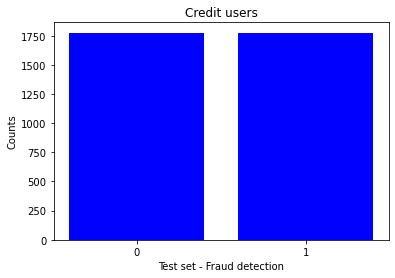

In [17]:
labels, counts = np.unique(y_test, return_counts=True)
plt.bar(labels, counts, align='center', color = "b")
plt.title('Credit users')
plt.xlabel('Test set - Fraud detection')
plt.ylabel("Counts")
plt.xticks(labels)
plt.show()

### Hiperparámetros
En un primer acercamiento al aprendizaje supervisado, pudiera parecer que construir modelos es tan simple como generar la instancia, entrenar, predecir y evaluar ... y aunque en producción esto es así, en realidad tenemos que probar varias "configuraciones" de nuestro modelo.

En machine learning existen dos términos que deben tomarse en cuenta: los parámetros del modelo, que se obtiene tras estimar el modelo, y los hiperparámetros, que deben ajustarse antes del entrenamiento y de la predicción.

Ahora bien, cada modelo tiene cierto número de hiperparámetros y cada uno de ellos puede tomar distintos valores, por lo que probar con cada combinación posible de hiperparámetros es una tarea totalmente laboriosa.

Afortunadamente, como científicos de datos, podemos desarrollar funciones que nos faciliten esta tarea y Scikit Learn está aquí para ayudarnos con esta importante labor.

Para ello utilizaremos la función "RandomizedSearchCV" la cual nos permite probar de forma aleatoria distintas combinaciones de hiperparámetros y realizar validación cruzada en cada una de ellas para determinar, con base en una métrica, cuáles son los hiperparámetros que generan el mejor modelo de clasificación.

La función RandomizedSearchCV toma 3 argumentos principales:
      1) La instancia del modelo a entrenar
      2) Un diccionario con todos los hiperparámetros a probar
      3) El número de validaciones cruzadas a realizar

In [18]:
from sklearn.model_selection import RandomizedSearchCV

### Regresión logística

In [19]:
# Diccionario de hiperparámetros
param_grid = {"C": np.logspace(-1, 1, 5),
                "penalty": ['l1', 'l2', 'elasticnet']}

# Instancia del modelo
LogisticRegression = LogisticRegression()

In [20]:
# Ajuste de hiperparámetros y entrenamiento
LogisticRegression_cv = RandomizedSearchCV(LogisticRegression, param_grid, cv = 5)
LogisticRegression_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ]),
                                        'penalty': ['l1', 'l2', 'elasticnet']})

In [21]:
# Hiperparámetros que generan el mejor modelo
print("Regresión logística con hiperparámetros ajustados: {}".format(LogisticRegression_cv.best_params_))

Regresión logística con hiperparámetros ajustados: {'penalty': 'l2', 'C': 0.1}


In [22]:
# Evaluación
print("Precisión del modelo en el subconjunto de entrenamiento: {}".format(LogisticRegression_cv.best_score_.round(2)))
print("Precisión del modelo en el subconjunto de prueba: {}".format(LogisticRegression_cv.score(X_test, y_test).round(2)))

Precisión del modelo en el subconjunto de entrenamiento: 0.89
Precisión del modelo en el subconjunto de prueba: 0.89


### Máquina de Soporte Vectorial

In [23]:
# Hiperparámetros
param_grid = {'C': np.logspace(-1, 1, 5),
                'gamma':[0.01, 0.1, 1]}

# Instancia del modelo
SVC = SVC()

In [24]:
# Ajuste de hiperparámetros y entrenamiento
SVC_cv = RandomizedSearchCV(SVC, param_grid, cv = 5)
SVC_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ]),
                                        'gamma': [0.01, 0.1, 1]})

In [25]:
# Hiperparámetros que generan el mejor modelo
print("Maquina de soporte vectorial con hiperparámetros ajustados: {}".format(SVC_cv.best_params_))

Maquina de soporte vectorial con hiperparámetros ajustados: {'gamma': 1, 'C': 10.0}


In [26]:
print("Precisión del modelo en el subconjunto de entrenamiento: {}".format(SVC_cv.best_score_.round(2)))
print("Precisión del modelo en el subconjunto de prueba: {}".format(SVC_cv.score(X_test, y_test).round(2)))

Precisión del modelo en el subconjunto de entrenamiento: 1.0
Precisión del modelo en el subconjunto de prueba: 0.71


### Red Neuronal Artificial

In [27]:
# Hiperparámetros
param_grid = {
    'activation': ['logistic', 'tanh'],
}

# Instancia del modelo
ANN = MLPClassifier()

In [28]:
# Ajuste de hiperparámetros y entrenamiento
ANN_cv = RandomizedSearchCV(ANN, param_grid, cv = 3)
ANN_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=MLPClassifier(),
                   param_distributions={'activation': ['logistic', 'tanh']})

In [29]:
# Hiperparámetros que generan el mejor modelo
print("Red Neuronal Artificial con hiperparámetros ajustados: {}".format(ANN_cv.best_params_))

Red Neuronal Artificial con hiperparámetros ajustados: {'activation': 'tanh'}


In [30]:
print("Precisión del modelo en el subconjunto de entrenamiento: {}".format(SVC_cv.best_score_.round(4)))
print("Precisión del modelo en el subconjunto de prueba: {}".format(SVC_cv.score(X_test, y_test).round(4)))

Precisión del modelo en el subconjunto de entrenamiento: 0.9975
Precisión del modelo en el subconjunto de prueba: 0.712


## Automatización

Supongamos que durante el último mes, el banco ha registrado, en algunas cuentas de sus clientes, movimientos que posiblemente son fraudulentos ... ¿cómo podría ayudarnos nuestro modelo?

In [31]:
# Usemos la muestra aleatoria que extrajimos al inicio del ejercicio para simular nuevos datos
X_sample.head()

,balance,purchases,installments_purchases,cash_advance,credit_limit,payments,minimum_payments
cust_id,,,,,,,
C14961,2671.979402,1469.66,42.23,2150.272488,3000.0,4047.049777,1682.737989
C11349,831.404268,0.00,0.00,5579.552147,3500.0,8450.958983,243.343542
C11002,1651.127455,720.18,241.65,0.000000,5000.0,0.000000,864.173246
C15220,6.226972,54.00,54.00,0.000000,3000.0,0.000000,864.173246
C13632,971.268179,2336.32,490.33,0.000000,4000.0,299.485824,252.187792


In [32]:
# Debemos transformar nuevamente nuestras variables explicativas
X_new = np.array(X_sample)
X_new_pwt = pwt.fit_transform(X_new)

In [33]:
# Vamos a usar nuestro modelo para predecir qué clientes han tenido movimientos potencialmente fraudulentos
y_new_pred = ANN_cv.predict(X_new_pwt)
with np.printoptions(threshold=np.inf):
    print(y_new_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 